# Filtrando ruído com autoencoder convolucional

Nesta aplicação o autocodificador é utilizado como filtro de ruído. 
Utiliza-se o dataset do MNIST, adicionando ruído gaussiano.
A rede é treinada com a entrada com a imagem ruidosa e a saída como a imagem original.

Esta é uma rede totalmente convolucional e para tanto, a rede aceita imagens de entrada de quaisquer dimensões.

## Importando as bibliotecas

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image

#import codecs
#import errno
import os
import os.path

# from torch
import torch
from torch import nn
from torch.autograd import Variable
import torch.utils.data as data

# from torchvision
import torchvision
from torchvision import transforms
from torchvision.datasets.mnist import read_image_file

In [2]:
# verifica se a GPU esta disponivel
use_gpu = torch.cuda.is_available()
print("Usando GPU:", use_gpu)

Usando GPU: False


## Classe para carregar os dados e adicionar ruído

In [3]:
class MNIST_Noise(data.Dataset):
    """`MNIST <http://yann.lecun.com/exdb/mnist/>`_ Dataset.
    Args:
        root (string): Root directory of dataset where ``processed/training.pt``
            and  ``processed/test.pt`` exist.
        train (bool, optional): If True, creates dataset from ``training.pt``,
            otherwise from ``test.pt``.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    """
    urls = [
        'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
    ]
    raw_folder = 'raw'
    processed_folder = 'processed'
    training_file = 'training.pt'
    test_file = 'test.pt'

    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.target_transform = target_transform
        self.train = train  # training set or test set

        if download:
            self.download()

        if not self._check_exists():
            raise RuntimeError('Dataset not found.' +
                               ' You can use download=True to download it')

        if self.train:
            self.train_data, self.train_labels = torch.load(
                os.path.join(self.root, self.processed_folder, self.training_file))
        else:
            self.test_data, self.test_labels = torch.load(
                os.path.join(self.root, self.processed_folder, self.test_file))

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        if self.train:
            img, target = self.train_data[index], self.train_labels[index]
        else:
            img, target = self.test_data[index], self.test_labels[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode='L')
        target = Image.fromarray(target.numpy(), mode='L')

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        if self.train:
            return len(self.train_data)
        else:
            return len(self.test_data)

    def _check_exists(self):
        return os.path.exists(os.path.join(self.root, self.processed_folder, self.training_file)) and \
            os.path.exists(os.path.join(self.root, self.processed_folder, self.test_file))

    def download(self):
        """Download the MNIST data if it doesn't exist in processed_folder already."""
        from six.moves import urllib
        import gzip

        if self._check_exists():
            return

        # download files
        try:
            os.makedirs(os.path.join(self.root, self.raw_folder))
            os.makedirs(os.path.join(self.root, self.processed_folder))
        except OSError as e:
            if e.errno == errno.EEXIST:
                pass
            else:
                raise

        for url in self.urls:
            print('Downloading ' + url)
            data = urllib.request.urlopen(url)
            filename = url.rpartition('/')[2]
            file_path = os.path.join(self.root, self.raw_folder, filename)
            with open(file_path, 'wb') as f:
                f.write(data.read())
            with open(file_path.replace('.gz', ''), 'wb') as out_f, \
                    gzip.GzipFile(file_path) as zip_f:
                out_f.write(zip_f.read())
            os.unlink(file_path)

        # process and save as torch files
        print('Processing...')

        train_file = read_image_file(os.path.join(self.root, self.raw_folder, 'train-images-idx3-ubyte'))
        test_file = read_image_file(os.path.join(self.root, self.raw_folder, 't10k-images-idx3-ubyte'))
        
        # add noise
        train_noise = train_file + torch.from_numpy(np.random.normal(loc=0, scale=1, size=train_file.shape)).type(torch.ByteTensor)
        train_noise = torch.clamp(train_noise, 0, 255)
        
        test_noise = test_file + torch.from_numpy(np.random.normal(loc=0, scale=1, size=test_file.shape)).type(torch.ByteTensor)
        test_noise = torch.clamp(test_noise, 0, 255)
        
        # create sets
        training_set = (
            train_noise,
            train_file
        )
        test_set = (
            test_noise,
            test_file
        )
        with open(os.path.join(self.root, self.processed_folder, self.training_file), 'wb') as f:
            torch.save(training_set, f)
        with open(os.path.join(self.root, self.processed_folder, self.test_file), 'wb') as f:
            torch.save(test_set, f)

        print('Done!')


## Carregando e mostrando os dados

In [4]:
dataset_dir = './data/datasets/MNIST_Noise/'

# Transformara os dados em tensores no intervalo [0.0, 1.0] (Os dados serão normalizados)
data_transform = transforms.ToTensor()

# carrega o conjunto de treinamento e de teste
mnist_datasets = {
    'train' : MNIST_Noise(dataset_dir, train=True, transform=data_transform, target_transform=data_transform, download=True),
    'val'   : MNIST_Noise(dataset_dir, train=False, transform=data_transform, target_transform=data_transform, download=True),
}

print('amostras para treinamento:', len(mnist_datasets['train']))
print('amostras para validação:',   len(mnist_datasets['val']))

Processing...
Done!
amostras para treinamento: 60000
amostras para validação: 10000


## Mostrando algumas imagens do conjunto de treinamento

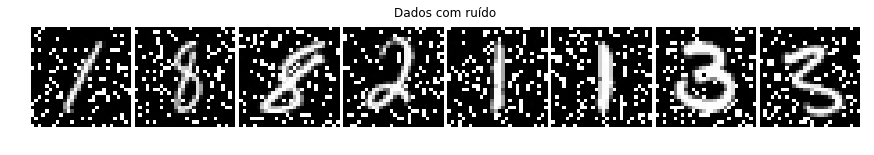

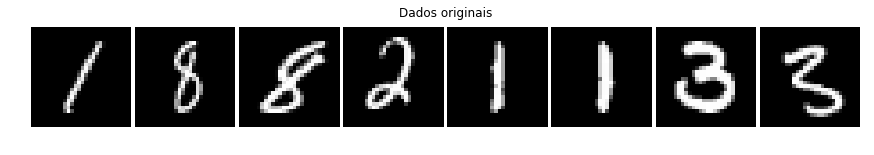

In [10]:
n_samples = 8

# cria um DataLoader temporario para pegar um batch de 'n_samples' imagens de treinamento
temp_dataloader = torch.utils.data.DataLoader(mnist_datasets['train'], 
                                              batch_size = n_samples,
                                              shuffle=True, num_workers=4)

# pega um batch de imagens
image_batch, labels = next(iter(temp_dataloader))

# cria um grid com as imagens
grid_data = torchvision.utils.make_grid(image_batch, normalize=True, pad_value=1.0, padding=1)
grid_labels = torchvision.utils.make_grid(labels, normalize=True, pad_value=1.0, padding=1)

# dados com ruído
plt.figure(figsize=(15, 10))
plt.title("Dados com ruído")
plt.imshow(grid_data.numpy().transpose(1, 2, 0))
plt.axis('off')
plt.show()
# dados originais
plt.figure(figsize=(15, 10))
plt.title("Dados originais")
plt.imshow(grid_labels.numpy().transpose(1, 2, 0))
plt.axis('off')
plt.show()

del temp_dataloader

## Cria DataLoader para os dados

In [13]:
train_loader = torch.utils.data.DataLoader(mnist_datasets['train'],
                                          batch_size=64,
                                          shuffle=True,
                                          num_workers=1)

val_loader = torch.utils.data.DataLoader(mnist_datasets['val'],
                                         batch_size=10000,
                                         shuffle=False,
                                         num_workers=2)

## Definição das classes que representam as redes

In [6]:
import torch.nn.functional as F

# classe do AutoEncoder (Encoder + Decoder)
class AutoEncoder(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super(AutoEncoder, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# classe do Encoder
class Encoder(torch.nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.encode_conv1 = torch.nn.Conv2d(1, 16, 3, stride=3, padding=1)
        self.encode_pool1 = torch.nn.MaxPool2d(2, stride=2)
        self.encode_conv2 = torch.nn.Conv2d(16, 8, 3, stride=2, padding=1)
        self.encode_pool2 = torch.nn.MaxPool2d(2, stride=1)

    def forward(self, x):
        x = F.relu(self.encode_conv1(x))
        x = self.encode_pool1(x)
        x = F.relu(self.encode_conv2(x))
        x = self.encode_pool2(x)
        return x

# classe do Decoder
class Decoder(torch.nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.decode_conv1 = torch.nn.ConvTranspose2d(8, 16, 3, stride=2)
        self.decode_conv2 = torch.nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1)
        self.decode_conv3 = torch.nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1)
        
    def forward(self, x):
        x = F.relu(self.decode_conv1(x))
        x = F.relu(self.decode_conv2(x))
        x = F.tanh(self.decode_conv3(x))
        return x

## Rede autoencoder

In [11]:
autoencoder = AutoEncoder(Encoder(), Decoder())
if use_gpu:
    autoencoder = autoencoder.cuda()

In [ ]:
input_img = Input(shape=(None, None, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='linear', padding='same')(x)

autoencoder = Model(input_img,decoded)

## Sumário da rede

Observe que nesta rede, as dimensões das imagens em todas as camadas podem ser quaisquer, com exceção dos canais (última dimensão) que são 1 na entrada (imagem de cinza) e 1 na saída (imagem de cinza).
Assim, esta rede é dita totalmente convolucional, aceitando portanto imagens de cinza de qualquer tamanho.

In [8]:
print(autoencoder)

AutoEncoder(
  (encoder): Encoder(
    (encode_conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (encode_pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (encode_conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (encode_pool2): MaxPool2d(kernel_size=(2, 2), stride=(1, 1), dilation=(1, 1), ceil_mode=False)
  )
  (decoder): Decoder(
    (decode_conv1): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (decode_conv2): ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (decode_conv3): ConvTranspose2d(8, 1, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
  )
)


## Poucas amostras para teste inicial

In [ ]:
testing = True
if testing:
    n_samples = 1000
    x_train = x_train[:n_samples]
    x_train_noisy = x_train_noisy[:n_samples]
    
    n_samples_test = 200
    x_test = x_test[:n_samples_test]
    x_test_noisy = x_test_noisy[:n_samples_test]
print(x_train.shape, x_train_noisy.shape)

In [ ]:
print(x_train[0].mean(),x_train_noisy[0].mean())

In [14]:
def prediction(loader, model, loss_fn):
    for data in loader:
        images, labels = data
        
        # forward pass
        outputs = model(Variable(images))

        # loss
        loss = loss_fn(outputs, Variable(images))
    return (loss.data[0])

## Treinamento da rede

In [16]:
import copy
from time import time

epochs = 100
last_epoch = epochs - 1
patience = 10
patience_count = 0
best_model = []
best_val_loss = 999
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3, weight_decay=1e-5)

# histórico de acurácia e perda
train_loss = np.empty(epochs)
val_loss = np.empty(epochs)
    
for t in range(epochs):
    start_time = time()
    for i, data in enumerate(train_loader):
        # pega entradas
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels.type(torch.LongTensor))

        # forward pass
        predict = autoencoder(inputs)

        # loss
        loss = loss_fn(predict, inputs)

        # zera gradiente
        optimizer.zero_grad()
            
        # calcula novos gradientes
        loss.backward()

        # atualiza pesos
        optimizer.step()

    elapsed_time = time() - start_time
    # perda no conjunto de treinamento
    train_loss[t] = prediction(train_loader, autoencoder, loss_fn)
    # perda no conjunto de teste
    val_loss[t] = prediction(val_loader, autoencoder, loss_fn)
    # imprime dados do treinamento
    print('Epoch:', t, '-',round(elapsed_time,0),'s',
          '\t train loss:', round(train_loss[t],5), 
          '\t val loss:', round(val_loss[t],5))

    # verifica melhora do modelo
    if(best_val_loss > val_loss[t]):
        patience_count = 0
        best_val_loss = val_loss[t]
        best_model = copy.deepcopy(autoencoder)
        print('Loss improved, saving model from epoch', t)

    # early stop
    if(patience_count > patience):
        print('\nEarly stopping as accuracy did not improve on last', patience, 'epochs!')
        last_epoch = t
        break;

    patience_count += 1

# recupera melhor modelo
autoencoder = best_model
print('Trainning completed!')

Epoch: 0 - 13.0 s 	 train loss: 0.14572 	 val loss: 0.14335
Loss improved, saving model from epoch 0
Epoch: 1 - 14.0 s 	 train loss: 0.14085 	 val loss: 0.13651
Loss improved, saving model from epoch 1
Epoch: 2 - 13.0 s 	 train loss: 0.13863 	 val loss: 0.13488
Loss improved, saving model from epoch 2
Epoch: 3 - 14.0 s 	 train loss: 0.13584 	 val loss: 0.13352
Loss improved, saving model from epoch 3
Epoch: 4 - 13.0 s 	 train loss: 0.13604 	 val loss: 0.1324
Loss improved, saving model from epoch 4
Epoch: 5 - 13.0 s 	 train loss: 0.1345 	 val loss: 0.13166
Loss improved, saving model from epoch 5
Epoch: 6 - 15.0 s 	 train loss: 0.13608 	 val loss: 0.13124
Loss improved, saving model from epoch 6
Epoch: 7 - 16.0 s 	 train loss: 0.13394 	 val loss: 0.13095
Loss improved, saving model from epoch 7
Epoch: 8 - 15.0 s 	 train loss: 0.13262 	 val loss: 0.13096
Epoch: 9 - 17.0 s 	 train loss: 0.13374 	 val loss: 0.13066
Loss improved, saving model from epoch 9
Epoch: 10 - 14.0 s 	 train loss: 

In [ ]:
model_name = '../../models/FiltrandoRuidoAutoencoder'
fit_params = {
    'model_name': model_name,
    'loss':       'mse',
    'opt':        Adam(),
    'batch_size': 32, 
    'nepochs':    50,
    'patience':   5,
    'ploss':      0.07,
    'reset':      False,
}

autoencoder_trained,_ = train_network(autoencoder, x_train_noisy, x_train, x_test_noisy, x_test, **fit_params);

## Testando 10 primeiras amostras de teste

In [ ]:
y_hat = autoencoder_trained.predict(x_test_noisy[:10],batch_size=10)
print(y_hat.shape)

In [ ]:
n = 10
fig = plt.figure(figsize=(20, 4))
plt.gray()
for i in range(n):
    ax = fig.add_subplot(2, 10, i+1)
    ax.imshow(x_test_noisy[i].reshape(28, 28))
    ax.axis('off')
for i in range(n):
    ax = fig.add_subplot(2, 10, i+11)
    ax.imshow(y_hat[i].reshape(28, 28))
    ax.axis('off')
plt.show();

## Testando com imagem de tamanho maior

Como a rede é formada de camadas convolucionais, é possível que a imagem de entrada tenha qualquer tamanho.
Veja o exemplo a seguir, onde 4 imagens são juntadas para formar uma de shape=(56,56).

In [ ]:
img1 = np.hstack([x_test_noisy[0],x_test_noisy[1]])
img2 = np.hstack([x_test_noisy[2],x_test_noisy[3]])
img = np.vstack([img1,img2]).reshape(1,56,56,1)
print(img.shape)
plt.imshow(img.reshape(56,56),cmap='gray')
                 

In [ ]:
yy_hat = autoencoder_trained.predict(img,batch_size=1)
plt.imshow(yy_hat.reshape(56,56),cmap='gray');

## Aprendizados